---

# <center> AI / ML Project - Forecasting Air Passengers 

---

### Description:

A simple yet challenging project, to forecast the volume of air passengers, based on monthly totals of a US airline passengers from 1949 to 1960.
Can you overcome these obstacles & Forecast the future occupancies of the Airlines?

This data frame contains the following columns:
* Month : The month of observation
* #Passengers : Total Passengers travelled in that particular month

### Objectives:
- Understand the Dataset & cleanup (if required).
- Perform the necessary checks like stationarity & DF on the Dataset.
- Build a forcasting model to predict the future volumne of the air passengers.

---

## <center> Stractegic Plan of Action:

1. Visualize the time series - Check for trend, seasonality, or random patterns.
2. Stationarize the series using decomposition or differencing techniques.
3. Plot ACF/PACF and find (p,d,q) parameters.
4. Building the forecasting model - can be AR, MA, ARMA or ARIMA.
5. Making Predictions using the Forecasting Model

---

## <center>Visualizing the Time Series

In [1]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv('/Users/vinay/Desktop/WeeTech Solution Pvt. Ltd/Time Series/AirPassengers/AirPassengers.csv')
df.Month = df.Month.apply(lambda x : dt(int(x[:4]),int(x[5:]),15))
df.set_index('Month', inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121



Inference: The Datset consists of 1 features & 144 samples.


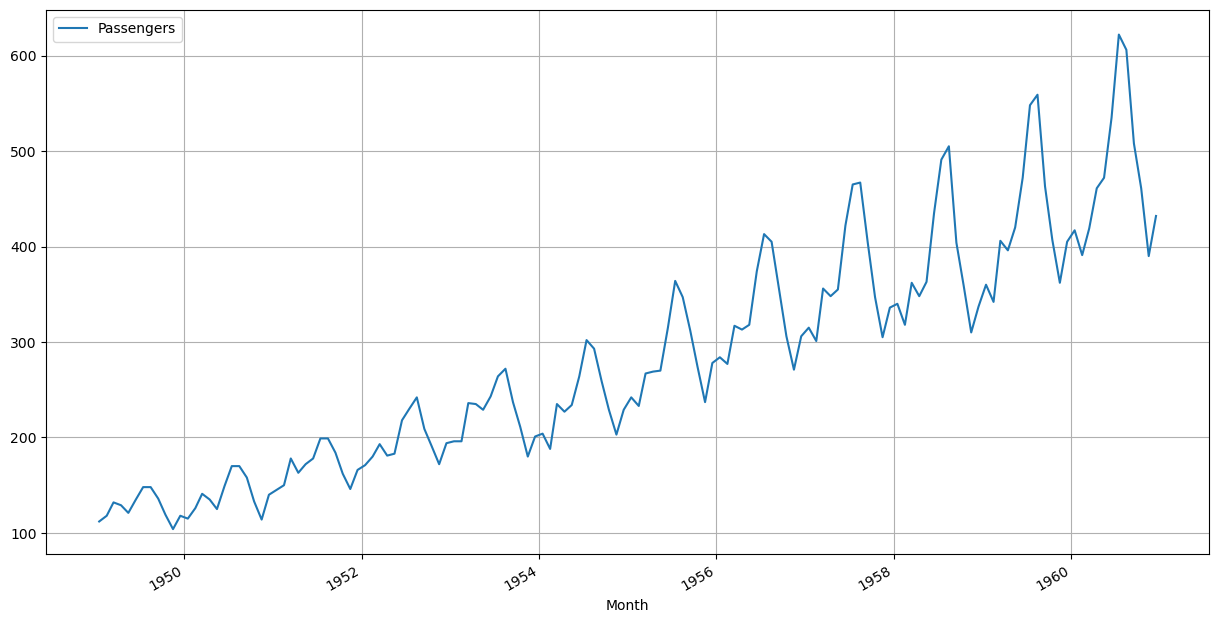

In [3]:
#Plotting the Timeseries

df.plot()
plt.grid()
plt.show()

**Inference:** It's clear from the plot that there is an uptrend in the volumne of Passengers, with some seasonality. Let us perform stationarity check using visual (rolling mean & std) & statistical tests ( Dicky-Fooler's Test) to confirm the same.

---

## <center>Stationarize the Series

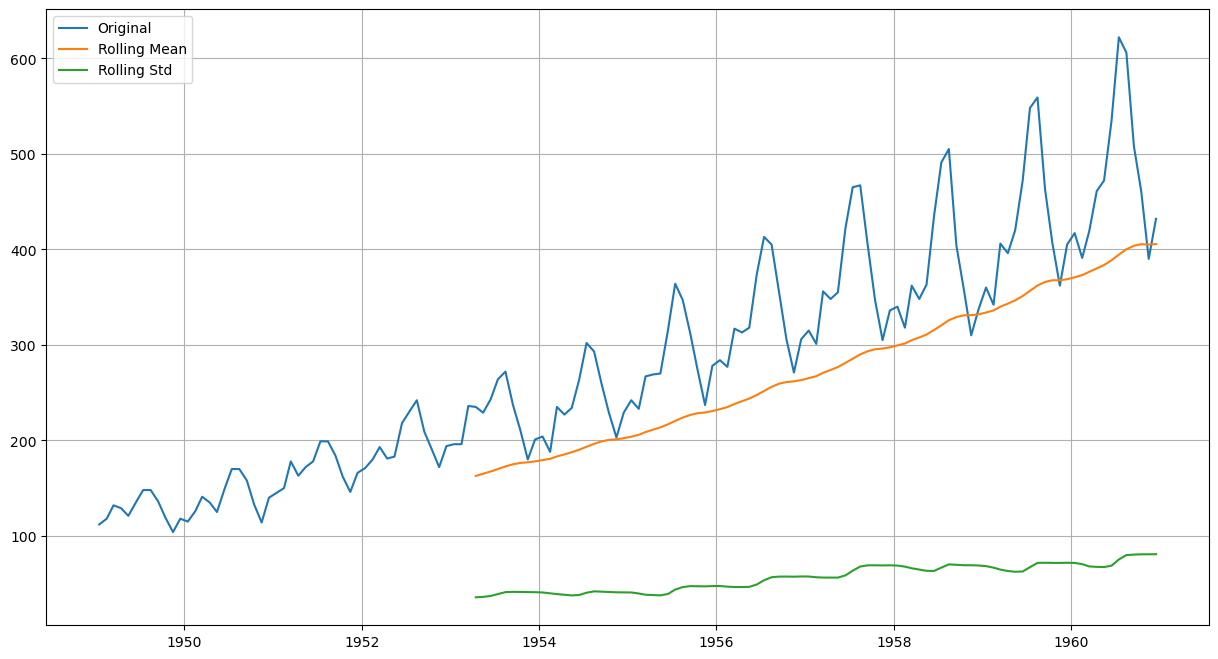

T Statistic             0.815369
P-Value                 0.991880
Lags Used              13.000000
Observations Used     130.000000
Critical value 1%      -3.481682
Critical value 5%      -2.884042
Critical value 10%     -2.578770
dtype: float64


In [4]:
#Stationary Check

from statsmodels.tsa.stattools import adfuller

def Staionarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52, center=False).std(), label='Rolling Std')
    plt.grid()
    plt.legend()
    plt.show()
    
    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4], index=['T Statistic','P-Value','Lags Used','Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
    
Staionarity_Check(df['Passengers'])

**Inference:** Since the test statistic is higher than the critical value, & the rolling mean is not constant over time, therefore the null hypothesis cannot be rejected. This implies that the time-series is non-staionary!
Let us fix this by decomposing using moving average...

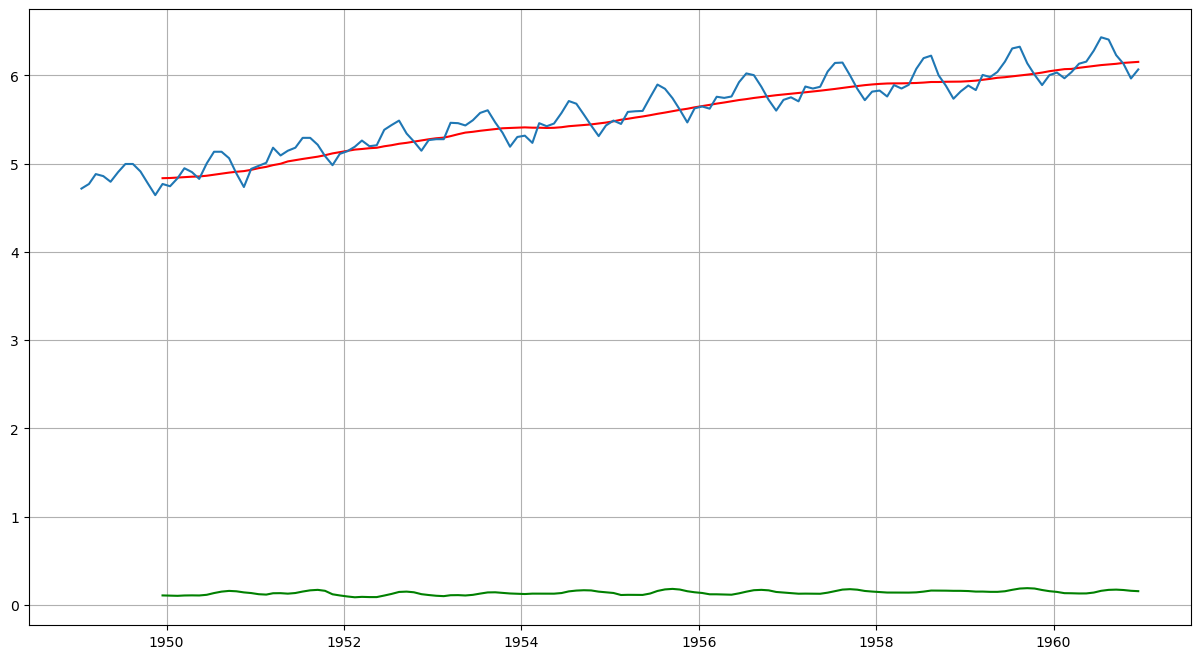

In [5]:
#Decomposing using moving average

tsl = np.log(df)
ma = tsl.rolling(window=12).mean()
ms = tsl.rolling(window=12).std()

plt.plot(ma, c='r')#, center=False)
plt.plot(ms, c='g')
plt.plot(tsl)
plt.grid()
plt.show()

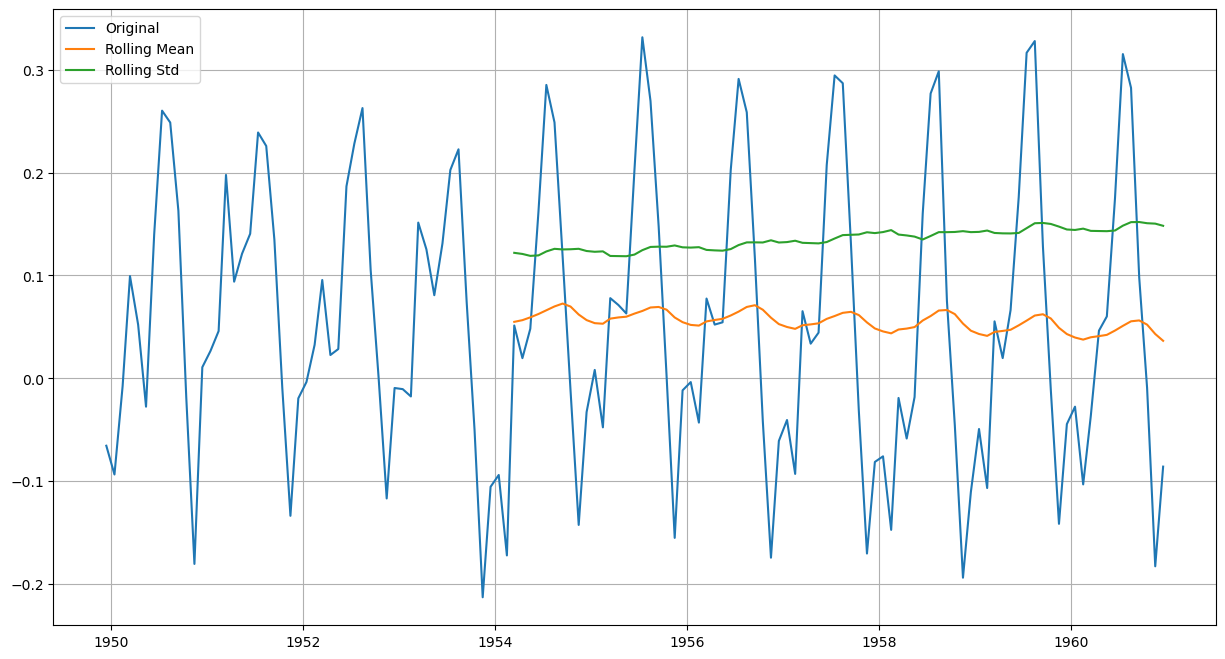

T Statistic            -3.162908
P-Value                 0.022235
Lags Used              13.000000
Observations Used     119.000000
Critical value 1%      -3.486535
Critical value 5%      -2.886151
Critical value 10%     -2.579896
dtype: float64


In [6]:
# Stationarity Check for Decomposed Time Series

tsl - np.log(df)
ma = tsl.rolling(window=12, center=False).mean()

tslma = tsl - ma
tslma = tslma.dropna()
Staionarity_Check(tslma)

**Inference**: Now the test staistic can be observed to be less that 5% critical value, hence the nullhypothsis can be rejected. Indicating that the time series is stationary & we can use it to create our ARIMA Model. But before that, let us find the parameters - `p` & `q` required by the model, by plotting Auto-Correlation Function & Partial Auto-Correlation Function.

---

## <center>Plotting ACF / PACF

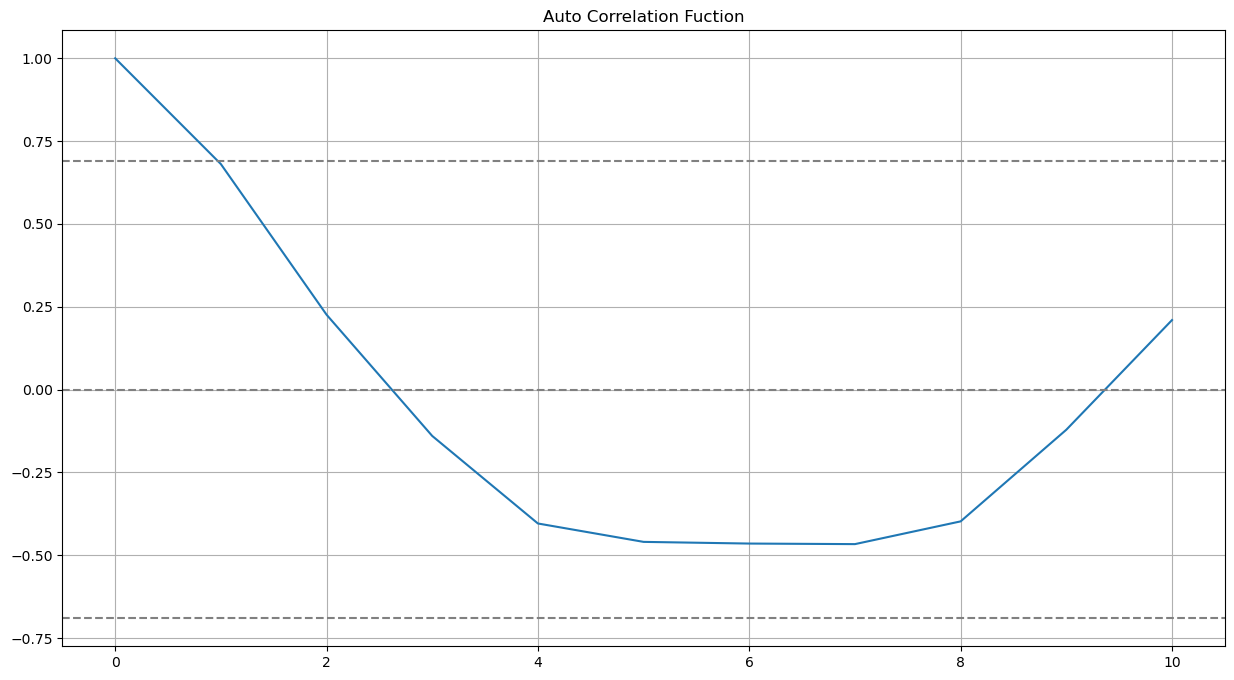

In [7]:
#Auto Correlation Fuction #q

from statsmodels.tsa.stattools import acf, pacf
plt.plot(np.arange(acf(tslma, nlags=10,fft=True).shape[0]),acf(tslma, nlags=10, fft=True))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Auto Correlation Fuction')
plt.grid()
plt.show()

**Inference:** The ACF Curve passes throught the upper confidence value when the lag value is between 0 & 1, hence the optimal value of `q` can be either 0 or 1.

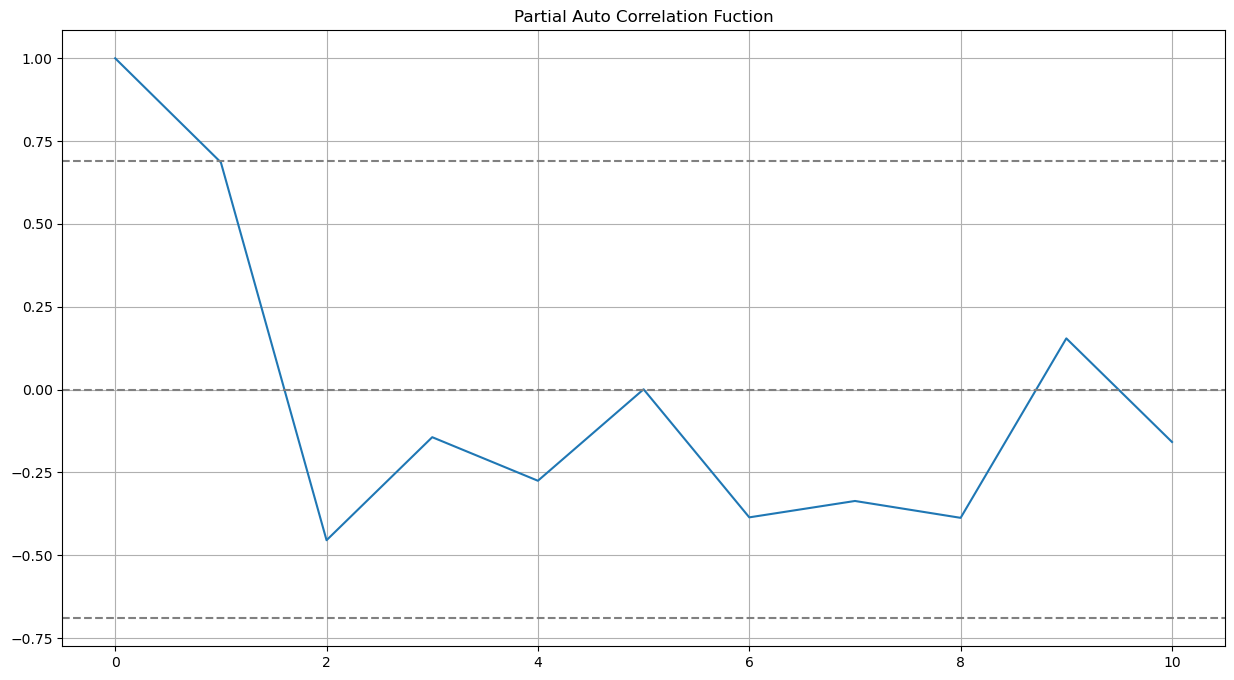

In [8]:
#Partial Auto Correlation Fuction #p

from statsmodels.tsa.stattools import acf, pacf
plt.plot(np.arange(pacf(tslma, nlags=10).shape[0]),pacf(tslma, nlags=10))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Partial Auto Correlation Fuction')
plt.grid()
plt.show()

**Inference:** The PACF Curve drops to 0 when the lag value is between 1 & 2, hence the optimal value of `p` can be either 1 or 2.

---

## <center>Model Building

/Users/vinay/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vinay/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vinay/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  133
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 116.431
Date:                Wed, 17 Jan 2024   AIC                           -226.861
Time:                        11:00:29   BIC                           -218.213
Sample:                             0   HQIC                          -223.347
                                - 133                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5899      0.137     -4.301      0.000      -0.859      -0.321
ma.L1          0.8981      0.074     12.209      0.000       0.754       1.042
sigma2         0.0100      0.002      5.696      0.000       0.007       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.38
Prob(Q):                              0.91   Prob(JB):                         0.07
Heteroskedasticity (H):               1.24   Skew:                            -0.01
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

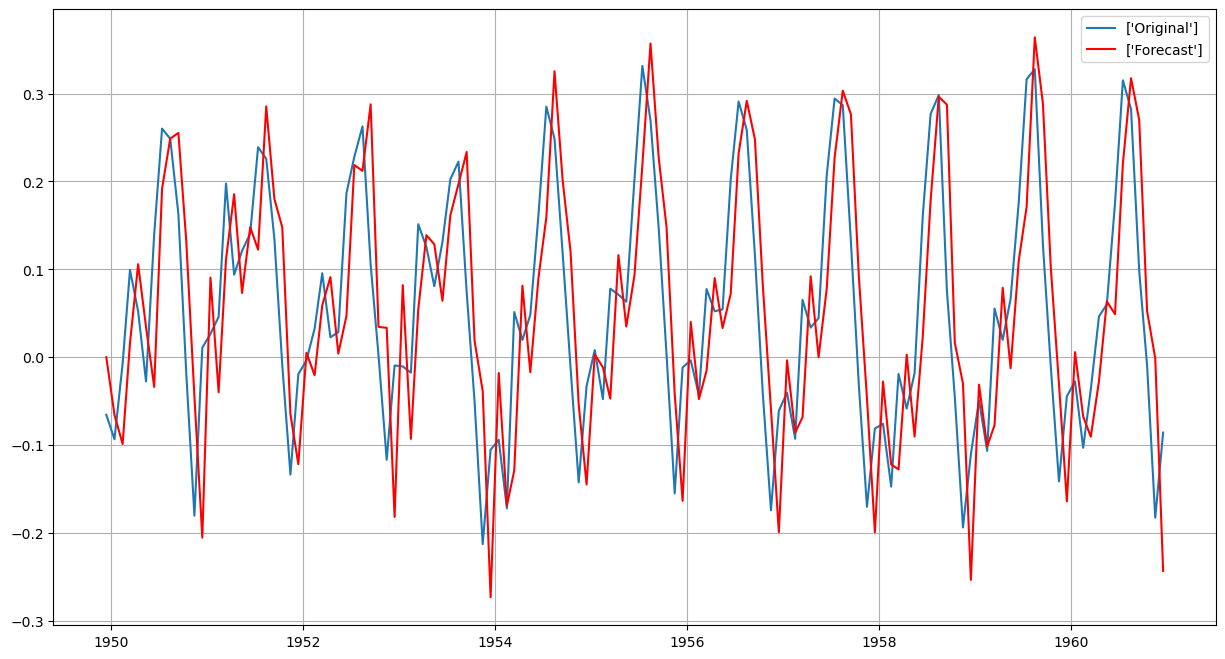

In [9]:
#Building ARIMA Model

from statsmodels.tsa.arima.model import ARIMA

Arima = ARIMA(tslma, order=(1,1,1))
Ar = Arima.fit()
plt.plot(tslma, label=['Original'])
plt.plot(Ar.fittedvalues,c='r', label=['Forecast'])
plt.legend()
plt.grid()

Ar.summary()

**Inference:** The Arima Model fits well on the time-series data with nearly perfect p-values. Let us now forcast the future data with the help of the trained ARIMA Model.

---

## <center>Forecasting

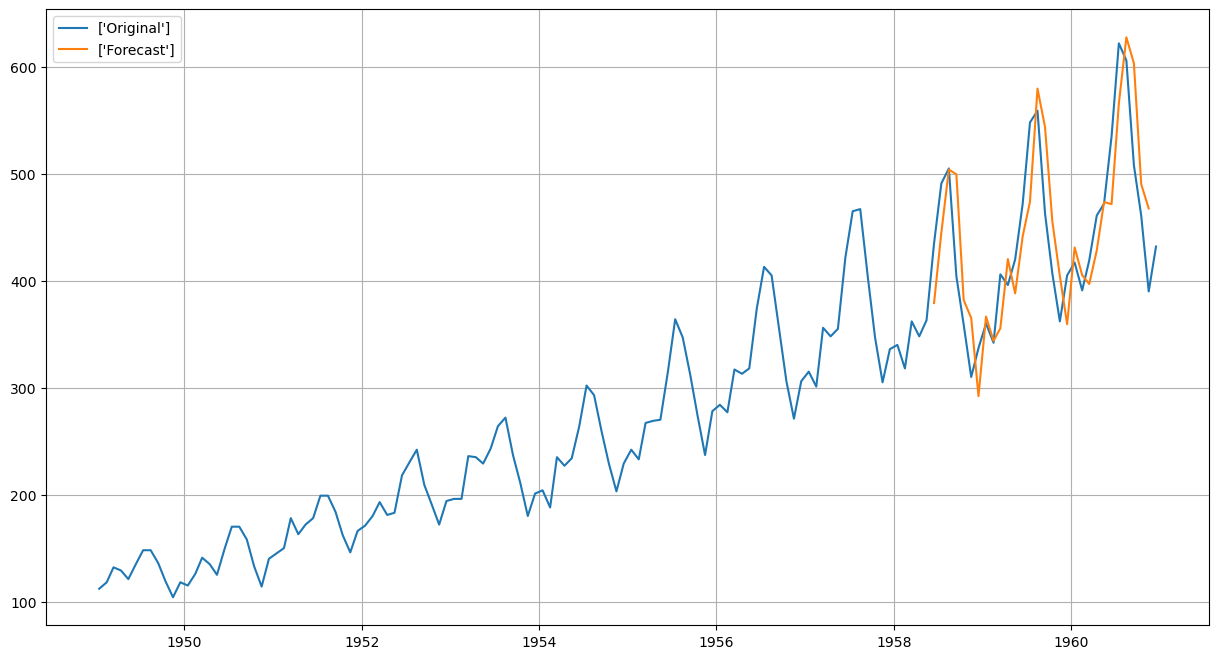

In [10]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['Passengers'] = Ar.predict(start =102, end = 131, dynamic= False)

plt.plot(df, label=['Original'])
plt.plot(np.exp(future_df+ma), label=['Forecast'])
plt.grid()
plt.legend()
plt.show()

**Inference:**<br>
The model's forecast seems to be precise as it captures most of the sesonality & possible trends in the time-series data.


---

## <center> Project Outcomes & Conclusions

### Here are some of the key outcomes of the project:
- The Air-Passengers Time-Series Dataset was quiet small, with just 144 samples.
- It was clear from the visuals that the time-series dataset had an upward trend & some seasonality.
- The same was confirmed with help of visual (rolling mean & std) & statistical (Dicky-Fuller Test) stionarity checks.
- The time-series was subject to Decomposition in order to stationarize the outputs.
- Futher ACF & PACF curves were plotted to extract the values of p & q, as it is required for the ARIMA Model.
- The Forecasting Model was then built with the time-series data, by feeding the optimal p,q,d values.
- Finally, the model was used to forecast the time-series of the air-passengers, into the future.

In [11]:
#<<<------------------------------------ THE END ---------------------------------------------------------------->>>